# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by November 8, 2018 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

_Hypothesis : _ 

$$\forall i\in[\![1,n]\!]\; Z_{i}\sim\mathcal{M}(k,\pi)\text{  and  }\forall j\in[\![1,k]\!]\; X_{i}\mid\{Z_{i}=j\}\sim\mathcal{N}(\mu_{j},\Sigma_{j})$$

---


 Let $\theta$ denote our set of parameters and $N$ the matrix given by :

$$
N_{ij} = p_{\theta}(X_{i}=x_{i}\mid Z_{i}=j) = \mathcal{N}\left(x_{i}\mid \mu_{j}, \Sigma_{j}\right)
$$

Let the responsability matrix $\gamma$ be

$$\gamma_{ij} = p_{\theta}(Z_{i}=j\mid X_{i})$$

Then, $\forall i,j$, $\gamma_{ij}$ is given by : $$\gamma_{ij} = \frac{\pi_{j}N_{ij}}{\pi^{T}N_{i,\cdot}}$$

__(E) Step__:

If $\ell$ is our log-likelihood, the Expectation step boils down to the computation of the following expectation w.r.t the law of $Z\mid \{X=x\}$ : 

$$\mathbb{E}_{Z\mid X=x}[\ell(\theta)] = \sum_{i=1}^{n}\sum_{j=1}^{k}\gamma_{ij}\log N_{ij} + \sum_{i=1}^{n}\sum_{j=1}^{k}\gamma_{ij}\log\pi_{j}$$

__(M) Step__:

We compute the MLE for each parameter, namely $\forall j\in[\![1,k]\!]$

$$
\hat{\pi}_{j} = \frac{1}{n}\sum_{i}\gamma_{ij}
$$
$$
\hat{\mu}_{j} = \frac{\sum_{i}\gamma_{ij}x_{i}}{\sum_{i}\gamma_{ij}}
$$

$$
\hat{\Sigma}_{j} = \frac{\sum_{i}\gamma_{ij}(x_{i}-\hat{\mu}_{j})(x_{i}-\hat{\mu}_{j})^{T}}{\sum_{i}\gamma_{ij}}
$$

which can be read as the observations, weighted by their probabilty to belong to a given class

In [32]:
class my_GMM():
    
    def __init__(self, k, initialization="kmeans"):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.initialization_ = initialization
        self.mu_ = None
        self.Sigma_ = None
        self.N_ = None
        self.pi_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, eps=10e-6, max_iter=10000):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def compute_condition_prob_matrix(X):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n, p = X.shape
            self.N_ = np.array([stats.multivariate_normal(self.mu_[k], self.Sigma_[k]).pdf(X) for k in range(self.k_)]).T
            self.cond_prob_ = self.N_*self.pi_
            for i in range(n):
                self.cond_prob_[i,:] = self.cond_prob_[i,:]/np.sum(self.cond_prob_[i,:]) 
            return self.cond_prob_
                
        def compute_expectation():
            '''Compute the expectation to check increment'''
            n = len(X)
            E_log_likelihood = np.sum(self.cond_prob_*np.log(self.N_)) + np.sum(self.cond_prob_*np.log(self.pi_))
            return E_log_likelihood
        
        def compute_estimators(X):
            '''Compute the MLE of the model parameters'''
            self.pi_ = np.mean(self.cond_prob_, axis=0)
            self.mu_ = [np.sum(X.T*self.cond_prob_[:,j], axis=1)/np.sum(self.cond_prob_[:,j]) for j in range(self.k_)]
            self.Sigma_ = []
            for j in range(self.k_):
                foo = np.array([gamma*np.matmul((x-self.mu_[j]).reshape(-1,1),(x-self.mu_[j]).reshape(1,-1)) 
                                for gamma, x in zip(self.cond_prob_[:,j], X)])
                foo = np.sum(foo)/np.sum(self.cond_prob_[:,j])
                self.Sigma_ += [foo]
            
        # kmeans initialization
        if self.initialization_ == "kmeans":
            kmeans_clstr = KMeans(n_clusters=self.k_)
            labels = kmeans_clstr.fit_predict(X)
            self.cond_prob_ = np.zeros((n, self.k_))
            for i in range(n):
                self.cond_prob_[i,labels[i]] = 1
        # else randomly initialize them
        else:
            self.cond_prob_ = np.random.rand(n, self.k_)
            
        compute_estimators(X)

        n_iter = 0
        l_c = 0
        conv_criteria = True
        
        while conv_criteria and n_iter < max_iter:
            conv_criteria = l_c
            
            compute_condition_prob_matrix(X)
            l_c = compute_expectation()
            compute_estimators(X)
            
            conv_criteria = np.abs(conv_criteria-l_c)<eps
        
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n, p = X.shape
        N_ = np.array([stats.multivariate_normal(self.mu_[k], self.Sigma_[k]).pdf(X) for k in range(self.k_)]).T
        cond_prob_ = N_*self.pi_
        for i in range(n):
            cond_prob_[i,:] = cond_prob_[i,:]/np.sum(cond_prob_[i,:]) 
        return cond_prob_
    
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_ = self.predict_proba(X)
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        return labels

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [92]:
def generate_dataset(n_samples, n_features, k, seed):

    np.random.seed(seed)

    n = n_samples
    p = n_features
    k = k

    mean = [10*np.random.rand()*np.random.randn(p) + 10*(np.random.rand()-0.5) for i in range(k)]
    foo =  [10*np.random.rand()*np.random.randn(p,p) + 10*(np.random.rand()-0.5)for i in range(k)]
    covariance = [np.matmul(A.T, A) for A in foo]

    theta = zip(mean, covariance)
    X = np.array([np.random.multivariate_normal(theta[idx][0], theta[idx][1]) for idx in np.random.choice(len(theta),n)])
    return X

In [102]:
seeds = [1, 5, 17, 2013]

X = {2: [generate_dataset(1000, 2, 2, seed) for seed in seeds],
     3: [generate_dataset(1000, 2, 3, seed) for seed in seeds]}

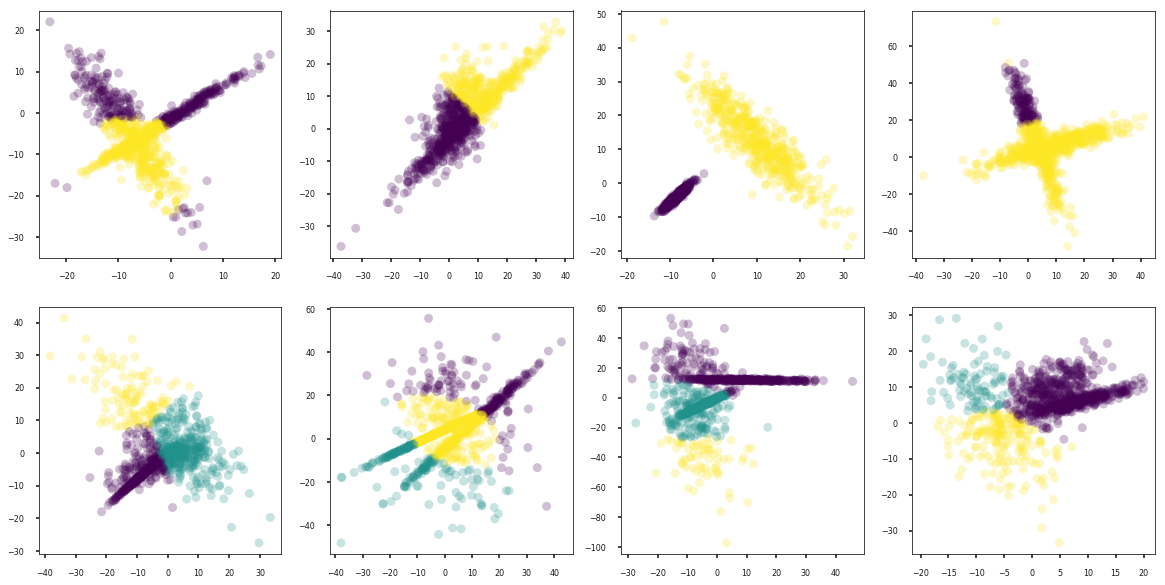

In [108]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

for i, item in enumerate(X.items()):
    for j, dataset in enumerate(item[1]):
        gmm = my_GMM(k=item[0])
        gmm.fit(dataset)
        ax[i][j].scatter(*dataset.T, c=gmm.labels_, **plot_kwds)
        ax[i][j].tick_params(axis='both', labelsize=8)

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
Implement the seen model selection methods (This part may be updated for the next lab)

In [ ]:
# TODO

## Application

You are going to work with the following data:

shape: (1797, 64)


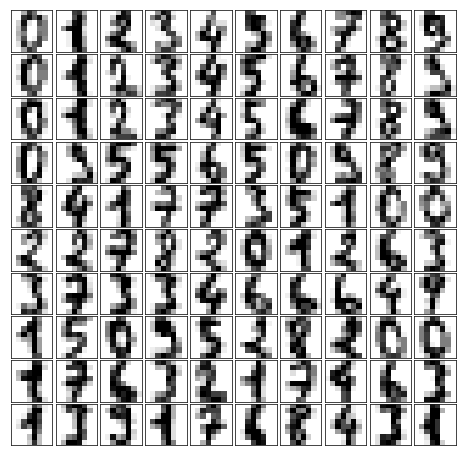

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method and produce new synthetic handwritten numbers. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [ ]:
# TODO